In [103]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import random
%matplotlib inline

In [104]:
# We continue form what we built last lecture
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [105]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [106]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
  
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [107]:
# MLP revisited (same we saw but without the input magic numbers)
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [108]:
# And we do the same optimization as last time
max_steps = 200000 # optimized number of steps
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 #output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backwards pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 #stop learning rate decay
    for p in parameters:
        p.data += -lr*p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 27.8817
  10000/ 200000: 2.7906
  20000/ 200000: 2.6104
  30000/ 200000: 2.8584
  40000/ 200000: 2.0437
  50000/ 200000: 2.5741
  60000/ 200000: 2.3921
  70000/ 200000: 2.1090
  80000/ 200000: 2.2418
  90000/ 200000: 2.3457
 100000/ 200000: 2.0623
 110000/ 200000: 2.3801
 120000/ 200000: 2.1086
 130000/ 200000: 2.4269
 140000/ 200000: 2.1813
 150000/ 200000: 2.1802
 160000/ 200000: 2.0950
 170000/ 200000: 1.8144
 180000/ 200000: 2.0726
 190000/ 200000: 1.9140


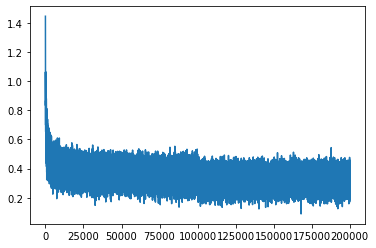

In [109]:
# we see again the loss
plt.plot(lossi)

In [110]:
# we compare the train loss and the val loss
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test':(Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # concat into(N, block_size*n_embed)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1250383853912354
val 2.1684672832489014


In [112]:
# and we finally sample from the model
#g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(10):
    out = []
    context = [0]*block_size
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        
        #sample from the distribution
        ix = torch.multinomial(probs, num_samples = 1, generator = g).item()
        
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        
        # if we sample the special '.' token we break
        if ix == 0:
            break
        
    # we print
    print(''.join(itos[i] for i in out))

chawry.
gir.
ego.
dazabeus.
josefynn.
zamarethy.
raniyan.
nylaylin.
kotana.
aleah.


In [10]:
# ------------------------------------------------------------------

In [73]:
# To start with this lecture we want to tackle the initialization, currently random
# we do not expect loss of 27, but a way lower number
# A first good guess for initi would be every characters proba to be uniform, 1/27
iniloss = -torch.tensor(1/27).log()
iniloss

tensor(3.2958)

In [74]:
# This can be sorted out multiplying by 0 b2 and scaling down W2
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * ((5/3)/((n_embd * block_size)**0.5))
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True
# Why not set W2 al to zero? We will see later, it has to do with the fact that we may not want them to be fully symmetric

12297


In [75]:
# Next problem arises when looking at the h
#h # We have a lot of 1 and -1 values, the tanh is squashing the embeded inputs

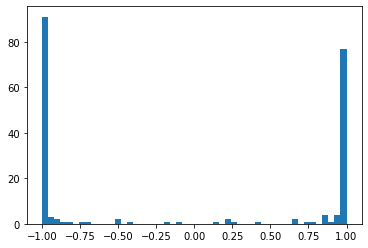

In [76]:
# To visualize better
plt.hist(h.view(-1).tolist(), 50);

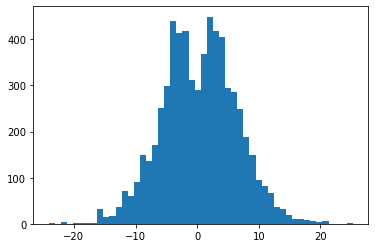

In [77]:
# This is because the preactivations inputed are very braod (-15 to 15)
plt.hist(hpreact.view(-1).tolist(), 50);

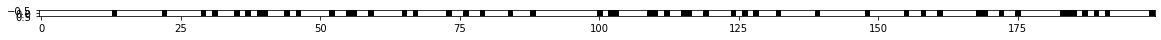

In [78]:
# To solve this we see
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation = 'nearest')
# We see a lot of white! meaning that the gradient that these neurons receive is close to 0

In [79]:
# Therefore we want hpreact close to 0, b1 we will set low, and same for the weights W1
# We see now a much more unspread gaussian
# In general this is done using
torch.randn(1000).std()

tensor(0.9990)

In [80]:
fan_in = n_embd * block_size
wanted_std = (5/3)/(fan_in)**0.5
# we incorporate this above, this function is also available in pytorch (init kaming normal)

In [81]:
# We may also want to introduce a modelrn innovation in nn: batch normalization
# The gist is basically instead of trying to construct hpreact as gaussian as possible (mean 0 std 1),
# we can just normalize them into gaussian (differentiable operation and therefore gradient acceptable)
hpreact.shape
#hpreact.mean(0, keepdim = True) # mean across the 0th dimension (1, 200)
#hpreact.std(0, keepdim = True)

torch.Size([32, 200])

In [82]:
# We include this in the optimization
hpreact = (hpreact - hpreact.mean(0, keepdim = True))/hpreact.std(0, keepdim = True)
# However, we only want to force gaussian (near) in the initialization
# We do this by the 'scale and shift' (see batch norm paper), this is added in the parameters cell

In [83]:
# And we do the same optimization as last time
max_steps = 200000 # optimized number of steps
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden pre-activation
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim = True))/hpreact.std(0, keepdim = True) + bnbias
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 #output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backwards pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 #stop learning rate decay
    for p in parameters:
        p.data += -lr*p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


In [85]:
# We must also include the batch normalization idea to the test
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test':(Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # concat into(N, block_size*n_embed)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim = True))/hpreact.std(0, keepdim = True) + bnbias
    h = torch.tanh(hpreact) 
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0668270587921143
val 2.104844808578491


In [88]:
# Now we work woth batches and the normaization forces us to have a distribuition of examples, not a single one.
# We can get around that with a fixed mean and std of the entire training dataset
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim = True)
    bnstd = hpreact.std(0, keepdim = True)

In [89]:
# Now, we add it into the split function
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test':(Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # concat into(N, block_size*n_embed)
    hpreact = embcat @ W1 + b1
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim = True))/hpreact.std(0, keepdim = True) + bnbias
    hpreact = bngain * (hpreact - bnmean)/bnstd + bnbias
    h = torch.tanh(hpreact) 
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
# And we can now also forward a single example

train 2.0668270587921143
val 2.1049270629882812


In [90]:
# We set again removing b1
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * ((5/3)/((n_embd * block_size)**0.5))
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True
# Why not set W2 al to zero? We will see later, it has to do with the fact that we may not want them to be fully symmetric

12097


In [91]:
# Instead of having it fixed forever however, we will calculate it in each iteration of the training
# And we do the same optimization as last time
max_steps = 200000 # optimized number of steps
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 #+ b1 # hidden pre-activation
    # Batchnorm
    bnmeani = hpreact.mean(0, keepdim = True)
    bnstdi = hpreact.std(0, keepdim = True)
    
    # update mean and std
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd + 0.001 * bnstdi
    
    hpreact = bngain * (hpreact - bnmeani)/bnstdi + bnbias
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 #output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 #stop learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


In [92]:
# compare
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test':(Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # concat into(N, block_size*n_embed)
    hpreact = embcat @ W1 + b1
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim = True))/hpreact.std(0, keepdim = True) + bnbias
    hpreact = bngain * (hpreact - bnmean)/bnstd + bnbias
    h = torch.tanh(hpreact) 
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
# And we can now also forward a single example

train 2.223217010498047
val 2.266387701034546


In [93]:
# Sample

In [94]:
# Last comments about batch normalization:
# 1) Careful with the possible division by zero on hpreact, we may want to add a very small number there
# 2) We do not need a bias (b1) before the batch normalization because it gets subtracted anywyas, so we comment it
# Instead, we have not the batch normalization bias (bnbias)

In [95]:
# ------------------------------------------------------------------

In [96]:
# We can try to pytorchify the code (see video and jupyter notebook)